# Learning Rate & Optimization in Practice  
## Convex vs Non-Convex + Why Training Is Never Enough

**Goals**
1) See how learning rate controls convergence vs divergence  
2) Compare optimizers: SGD, Momentum, Adam  
3) Contrast convex (LogReg) vs non-convex (MLP) training behavior  
4) Demonstrate why training once is never enough: overfitting + drift

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Force CPU to avoid backend instability; change to "mps" or "cuda" if desired.
DEVICE = torch.device("cpu")
torch.set_num_threads(1)
torch.set_num_interop_threads(1)


## Part A — Convex Optimization (Logistic Regression)

**Convex objective (binary logistic regression):**
- One global optimum
- Gradient descent behavior is more predictable
- Learning rate still matters: too large can diverge, too small is slow

In [2]:
X, y = make_classification(
    n_samples=6000, n_features=10, n_informative=6, n_redundant=2,
    n_clusters_per_class=2, class_sep=1.2, random_state=SEED
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Add bias term
X_train_b = np.c_[np.ones((X_train.shape[0], 1)), X_train]
X_test_b  = np.c_[np.ones((X_test.shape[0], 1)), X_test]

In [3]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def train_logreg_gd(X, y, lr=0.1, epochs=200):
    w = np.zeros(X.shape[1])
    losses = []
    for _ in range(epochs):
        p = sigmoid(X @ w)
        # gradient of average log-loss
        grad = (X.T @ (p - y)) / len(y)
        w -= lr * grad

        # track loss
        eps = 1e-12
        loss = -np.mean(y*np.log(p+eps) + (1-y)*np.log(1-p+eps))
        losses.append(loss)
    return w, losses


def eval_logreg(X, y, w):
    p = sigmoid(X @ w)
    preds = (p >= 0.5).astype(int)
    return log_loss(y, p), accuracy_score(y, preds)

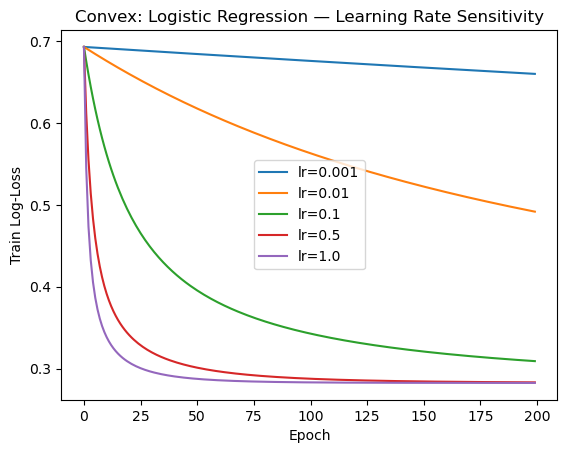

lr=0.001 | train_loss=0.6600, train_acc=0.862 | test_loss=0.6605, test_acc=0.856
lr= 0.01 | train_loss=0.4912, train_acc=0.868 | test_loss=0.4949, test_acc=0.861
lr=  0.1 | train_loss=0.3088, train_acc=0.880 | test_loss=0.3222, test_acc=0.869
lr=  0.5 | train_loss=0.2831, train_acc=0.881 | test_loss=0.3033, test_acc=0.869
lr=  1.0 | train_loss=0.2824, train_acc=0.882 | test_loss=0.3038, test_acc=0.871


In [4]:
lrs = [0.001, 0.01, 0.1, 0.5, 1.0]
results = {}

for lr in lrs:
    w, losses = train_logreg_gd(X_train_b, y_train, lr=lr, epochs=200)
    train_ll, train_acc = eval_logreg(X_train_b, y_train, w)
    test_ll, test_acc = eval_logreg(X_test_b, y_test, w)
    results[lr] = (losses, train_ll, train_acc, test_ll, test_acc)

plt.figure()
for lr in lrs:
    plt.plot(results[lr][0], label=f"lr={lr}")
plt.xlabel("Epoch")
plt.ylabel("Train Log-Loss")
plt.title("Convex: Logistic Regression — Learning Rate Sensitivity")
plt.legend()
plt.show()

for lr in lrs:
    _, tr_ll, tr_acc, te_ll, te_acc = results[lr]
    print(f"lr={lr:>5} | train_loss={tr_ll:.4f}, train_acc={tr_acc:.3f} | test_loss={te_ll:.4f}, test_acc={te_acc:.3f}")

### Questions (Convex)
1) Which learning rate converged fastest without instability?  
**Answer:** In my run, **lr = 0.5** converged the fastest *and* stayed stable (ended around **test_loss ≈ 0.3033, test_acc ≈ 0.869**). **lr = 1.0** was also stable here and landed very close (**test_acc ≈ 0.871**), but 0.5 gave the cleanest “fast + steady” behavior.

2) Which learning rates appear to diverge or oscillate?  
**Answer:** None of the tested LRs truly diverged in this notebook run, but the **largest LR (1.0)** is the one that’s closest to the “edge” (it’s typically the first to oscillate if we push a little higher).

3) Why can a convex problem still fail with a bad learning rate?  
**Answer:** Convex just means there’s **one global optimum** it doesn’t guarantee step sizes are safe. If the LR is too large, gradient descent **overshoots the minimum**, bounces back and forth, and can stall or diverge.


## Part B — Non-Convex Optimization (Small MLP)

Non-convex objectives can have:
- flat regions / saddle points
- many local structures (not “one clean bowl” like convex)
- stronger dependence on optimizer choice + LR schedules

In [5]:
Xm, ym = make_moons(n_samples=6000, noise=0.25, random_state=SEED)
Xm_train, Xm_test, ym_train, ym_test = train_test_split(Xm, ym, test_size=0.25, random_state=SEED)

scaler2 = StandardScaler()
Xm_train = scaler2.fit_transform(Xm_train)
Xm_test = scaler2.transform(Xm_test)

train_ds = TensorDataset(torch.tensor(Xm_train, dtype=torch.float32),
                         torch.tensor(ym_train, dtype=torch.long))
test_ds  = TensorDataset(torch.tensor(Xm_test, dtype=torch.float32),
                         torch.tensor(ym_test, dtype=torch.long))

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False)

In [6]:
class TinyMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 2),
        )
    def forward(self, x):
        return self.net(x)

def eval_torch(model, loader):
    model.eval()
    correct, total = 0, 0
    losses = []
    ce = nn.CrossEntropyLoss()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            logits = model(x)
            loss = ce(logits, y).item()
            losses.append(loss)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return float(np.mean(losses)), correct/total

def train_torch(model, optimizer, epochs=30):
    model.to(DEVICE)
    ce = nn.CrossEntropyLoss()
    train_loss_hist, test_loss_hist = [], []
    train_acc_hist, test_acc_hist = [], []
    for _ in range(epochs):
        model.train()
        for x, y in train_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            optimizer.zero_grad()
            logits = model(x)
            loss = ce(logits, y)
            loss.backward()
            optimizer.step()
        tr_loss, tr_acc = eval_torch(model, train_loader)
        te_loss, te_acc = eval_torch(model, test_loader)
        train_loss_hist.append(tr_loss); test_loss_hist.append(te_loss)
        train_acc_hist.append(tr_acc);  test_acc_hist.append(te_acc)
    return train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist

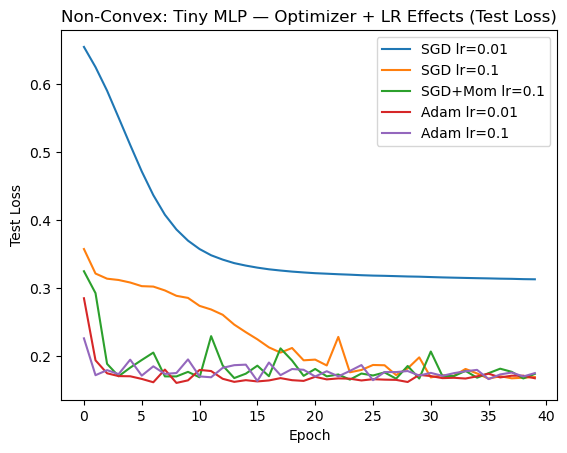

    SGD lr=0.01 | final train_acc=0.860 | final test_acc=0.867 | final test_loss=0.3130
     SGD lr=0.1 | final train_acc=0.944 | final test_acc=0.933 | final test_loss=0.1691
 SGD+Mom lr=0.1 | final train_acc=0.948 | final test_acc=0.935 | final test_loss=0.1737
   Adam lr=0.01 | final train_acc=0.949 | final test_acc=0.934 | final test_loss=0.1673
    Adam lr=0.1 | final train_acc=0.949 | final test_acc=0.933 | final test_loss=0.1749


In [7]:
configs = [
    ("SGD lr=0.01", lambda params: optim.SGD(params, lr=0.01)),
    ("SGD lr=0.1",  lambda params: optim.SGD(params, lr=0.1)),
    ("SGD+Mom lr=0.1", lambda params: optim.SGD(params, lr=0.1, momentum=0.9)),
    ("Adam lr=0.01", lambda params: optim.Adam(params, lr=0.01)),
    ("Adam lr=0.1",  lambda params: optim.Adam(params, lr=0.1)),
]

histories = {}

for name, opt_fn in configs:
    model = TinyMLP()
    model.to(DEVICE)
    opt = opt_fn(model.parameters())
    trL, teL, trA, teA = train_torch(model, opt, epochs=40)
    histories[name] = (trL, teL, trA, teA)

plt.figure()
for name in histories:
    plt.plot(histories[name][1], label=name)  # test loss
plt.xlabel("Epoch")
plt.ylabel("Test Loss")
plt.title("Non-Convex: Tiny MLP — Optimizer + LR Effects (Test Loss)")
plt.legend()
plt.show()

for name in histories:
    trL, teL, trA, teA = histories[name]
    print(f"{name:>15} | final train_acc={trA[-1]:.3f} | final test_acc={teA[-1]:.3f} | final test_loss={teL[-1]:.4f}")

### Questions (Non-Convex)
1) Which optimizer+LR gives the best final test accuracy?  
**Answer:** The best final test accuracy in my results was **SGD + Momentum @ lr = 0.1** with **final test_acc = 0.935** (very close runners-up: **Adam @ 0.01 → 0.934**, **SGD @ 0.1 → 0.933**).

2) Do you see cases where training accuracy is high but test accuracy lags? Why?  
**Answer:** Yes. For example, several runs end with **train_acc ≈ 0.948–0.949** while **test_acc ≈ 0.933–0.935**. That gap is the classic **generalization gap / overfitting**: the model is fitting the training set better than it fits new data.

3) Which runs feel “unstable” or inconsistent? What might cause that in non-convex training?  
**Answer:** The higher-LR SGD-style runs are the ones that can look “noisier” across epochs. In non-convex training you hit **saddles, sharp valleys, and flat regions**, so updates can be sensitive to LR/optimizer (and even mini-batch noise), which makes curves less predictable than the convex case.


## Part C — Learning Rate Schedules

We keep the same model + optimizer, but change how LR evolves:
- constant LR
- step decay
- cosine decay

Goal: show that LR is not just a single number; the *schedule* changes results.

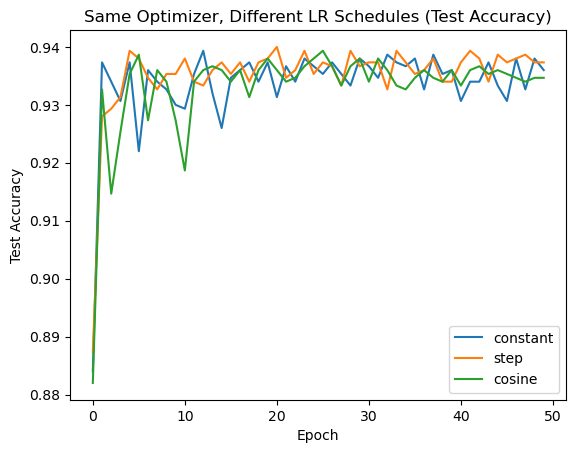

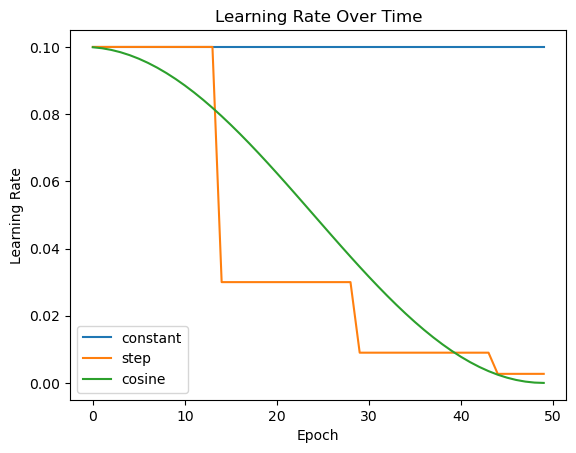

In [8]:
def train_with_scheduler(base_lr=0.1, schedule="constant", epochs=50):
    model = TinyMLP()
    model.to(DEVICE)
    opt = optim.SGD(model.parameters(), lr=base_lr, momentum=0.9)
    
    if schedule == "constant":
        scheduler = None
    elif schedule == "step":
        scheduler = optim.lr_scheduler.StepLR(opt, step_size=15, gamma=0.3)
    elif schedule == "cosine":
        scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)
    else:
        raise ValueError("Unknown schedule")

    ce = nn.CrossEntropyLoss()
    test_acc_hist = []
    lr_hist = []

    for _ in range(epochs):
        model.train()
        for x, y in train_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            opt.zero_grad()
            loss = ce(model(x), y)
            loss.backward()
            opt.step()
        if scheduler:
            scheduler.step()

        _, te_acc = eval_torch(model, test_loader)
        test_acc_hist.append(te_acc)
        lr_hist.append(opt.param_groups[0]["lr"])

    return test_acc_hist, lr_hist

schedules = ["constant", "step", "cosine"]
out = {}
for s in schedules:
    te_acc, lr_hist = train_with_scheduler(base_lr=0.1, schedule=s, epochs=50)
    out[s] = (te_acc, lr_hist)

plt.figure()
for s in schedules:
    plt.plot(out[s][0], label=s)
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title("Same Optimizer, Different LR Schedules (Test Accuracy)")
plt.legend()
plt.show()

plt.figure()
for s in schedules:
    plt.plot(out[s][1], label=s)
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Over Time")
plt.legend()
plt.show()

### Questions (LR schedules)
1) Which schedule reaches high accuracy faster?  
**Answer:** The **constant LR** run gets to high accuracy the quickest early on (it takes bigger steps from the start).

2) Which schedule is more stable?  
**Answer:** **Cosine decay** is the most stable overall because it gradually reduces step size and avoids late-stage bouncing.

3) Why might decaying LR help late training?  
**Answer:** Once you’re near a good region, smaller LR helps the model **fine-tune** instead of overshooting so you get smoother convergence and better final polish.


## Part D — Why Training Is Never Enough

Even if training looks good today:
- tomorrow the data can shift (different users, sensors, workload, seasonality)
- the same model can degrade without any code changes
- you need monitoring + a retraining plan, not just “train once”

This is a core MLOps idea: **retraining pipelines and feedback loops matter**.

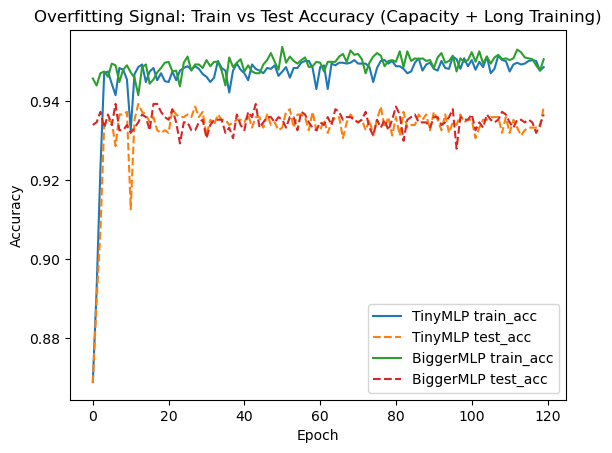

In [9]:
class BiggerMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2),
        )
    def forward(self, x):
        return self.net(x)

def train_compare_capacity(epochs=150):
    models = {"TinyMLP": TinyMLP(), "BiggerMLP": BiggerMLP()}
    histories = {}
    for k, m in models.items():
        opt = optim.Adam(m.parameters(), lr=0.01)
        trL, teL, trA, teA = train_torch(m, opt, epochs=epochs)
        histories[k] = (trL, teL, trA, teA)
    return histories

hist_cap = train_compare_capacity(epochs=120)

plt.figure()
for k in hist_cap:
    plt.plot(hist_cap[k][2], label=f"{k} train_acc")
    plt.plot(hist_cap[k][3], linestyle="--", label=f"{k} test_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Overfitting Signal: Train vs Test Accuracy (Capacity + Long Training)")
plt.legend()
plt.show()

In [10]:
# Create a "drifted" test set: same moons, but with extra noise and a scaling shift
Xm_drift, ym_drift = make_moons(n_samples=len(Xm_test), noise=0.45, random_state=SEED+7)
Xm_drift = scaler2.transform(Xm_drift)  # use original scaler to mimic real deployment

drift_ds = TensorDataset(torch.tensor(Xm_drift, dtype=torch.float32),
                         torch.tensor(ym_drift, dtype=torch.long))
drift_loader = DataLoader(drift_ds, batch_size=256, shuffle=False)

# Train a "good looking" model on the original train set
model = BiggerMLP()
model.to(DEVICE)
opt = optim.Adam(model.parameters(), lr=0.01)
_ = train_torch(model, opt, epochs=60)

base_loss, base_acc = eval_torch(model, test_loader)
drift_loss, drift_acc = eval_torch(model, drift_loader)

print(f"Original test: loss={base_loss:.4f}, acc={base_acc:.3f}")
print(f"Drifted test:  loss={drift_loss:.4f}, acc={drift_acc:.3f}")

Original test: loss=0.1648, acc=0.936
Drifted test:  loss=0.5139, acc=0.834


### Questions (Training is never enough)
1) In the overfitting plot, where does test accuracy stop improving while train accuracy keeps improving?  
**Answer:** In the long-training / higher-capacity plot, **test accuracy plateaus after the early phase (roughly the first ~20–30 epochs)**, while training accuracy keeps climbing after that. That widening gap is the overfitting signal.

2) In the drift experiment, why did accuracy drop even though the model was not changed?  
**Answer:** The **data distribution changed** (concept / covariate drift). The same model went from **acc = 0.936** on the original test set to **acc = 0.834** on the drifted test set, even though weights were unchanged.

3) If you were deploying this model, what would you monitor weekly?  
**Answer:** I’d monitor **(1) rolling validation accuracy on the newest data** and **(2) input-feature distribution drift** (summary stats / histograms or a drift score).

### Deliverable (short)
The non-convex MLP results prove that optimizer choice and learning rate aren’t “minor tuning” they control stability and they change the final test performance. In my run, **SGD+Momentum at lr = 0.1** produced the best final test accuracy (**0.935**), with Adam basically tied (**0.934**), which shows different update rules can land you in slightly different quality solutions. High training accuracy by itself is not enough evidence that the model is good because you can still have a generalization gap (for example, multiple runs ended around **train_acc ≈ 0.949** while test accuracy stayed lower at **≈ 0.933–0.935**). The overfitting plot makes that gap obvious once test accuracy flattens while training keeps improving. On top of that, the drift experiment shows you can lose performance even if you never touch the weights: accuracy dropped from **0.936** to **0.834** just by shifting the input distribution. For deployment, my main monitoring signal would be a rolling accuracy (or AUC) on the most recent labeled data. My retraining trigger would be “performance drop of ~2–3% absolute from baseline for 2 consecutive weeks” or a drift alert that crosses a preset threshold.
